In [ ]:
import numpy as np
import pandas as pd

from warnings import filterwarnings
filterwarnings('ignore')

![](https://miro.medium.com/max/1400/1*Q55X1gfHjKi1knx96UVdZQ.png)

In [ ]:
%%time
# read dataframe
df_train = pd.read_feather("../input/tps10-quantile/train.feather")
df_test = pd.read_feather("../input/tps10-quantile/test.feather")

sample_submission = pd.read_csv("../input/tabular-playground-series-oct-2021/sample_submission.csv")

In [ ]:
# prepare dataframe for modeling
X = df_train.drop(columns=["target"])
y = df_train["target"].copy()

test_data = df_test

In [ ]:
cat_cols = list(X.columns[(X.nunique() < 5)])
con_cols = list(X.columns[(X.nunique() >= 5)])
cat_cols_indices = [X.columns.get_loc(col) for col in cat_cols]
print(f"cat_cols: {cat_cols}")

In [ ]:
import optuna

study = optuna.load_study(study_name='tps10dnn', storage='sqlite:///../input/dnnoptuna/tps10dnn.db')

trials = study.trials
trials.sort(key=lambda t: t.values[0] if t.values is not None else 0)
trials = trials[-10:]
trials.reverse()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(
    n_bins=96,
    embedding_dim=16,
    layers_ba_0 = [ (120, False, 0.5) ],
    layers_ba_1 = [ (120, False, 0.5) ], 
    pre_width = 60, 
    concat = True,
    concat_do = 0.5,
    layers_aa = [ (120, False, 0.5) ],
    **kwargs
):
    x_ib = layers.Input((len(con_cols),))
    x_i  = layers.Input((len(cat_cols) + len(con_cols),))

    x0 = layers.Embedding(input_dim=n_bins, output_dim=embedding_dim)(x_ib)
    x0 = layers.Flatten()(x0)
    
    for layer_width, bn, dropout in layers_ba_0:        
        x0 = layers.Dense(layer_width, kernel_initializer=tf.keras.initializers.GlorotNormal())(x0)
        x0 = layers.Dropout(dropout)(x0)
        if bn:
            x0 = layers.BatchNormalization()(x0)
        x0 = layers.Activation("swish")(x0)
    x0 = layers.Dense(pre_width, kernel_initializer=tf.keras.initializers.GlorotNormal(), activation='swish')(x0)

    x1 = x_i
    for layer_width, bn, dropout in layers_ba_1:
        x1 = layers.Dense(layer_width, kernel_initializer=tf.keras.initializers.GlorotNormal())(x1)
        x1 = layers.Dropout(dropout)(x1)
        if bn:
            x1 = layers.BatchNormalization()(x1)
        x1 = layers.Activation("swish")(x1)
    x1 = layers.Dense(pre_width, kernel_initializer=tf.keras.initializers.GlorotNormal(), activation='swish')(x1)

    # mid
    if concat:
        x = layers.Concatenate()([x0, x1])
    else:
        x = layers.Add()([x0, x1])
    x = layers.Dropout(concat_do)(x)

    for layer_width, bn, dropout in layers_aa:
        x = layers.Dense(layer_width, kernel_initializer=tf.keras.initializers.GlorotNormal())(x)
        if bn:
            x = layers.BatchNormalization()(x)
        x = layers.Activation("swish")(x)

    x = layers.Dense(1, kernel_initializer=tf.keras.initializers.GlorotNormal(), activation = "sigmoid")(x)

    model = keras.models.Model(inputs = [x_ib, x_i], outputs = x)
    model.compile(
        loss="binary_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate=0.00012), 
        metrics=[tf.keras.metrics.AUC(name='aucroc')]
    )

    return model

![](https://twilio-cms-prod.s3.amazonaws.com/images/braceurselftf2.width-1000.jpg)

Oh wait, all good it's just

![](https://twilio-cms-prod.s3.amazonaws.com/images/1J0qUNlF4_3knKYtGvYYa-b_2v4JRGnjrg0HFweJPCS-g.width-1000_kzhLOUE.png)

In [ ]:
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer

for nr, trial in enumerate(trials):
    print("**"*20)
    print(f"Train Model {nr}")
    
    params = trial.params
    
    params["layers_ba_0"] = []
    for l in range(params["layercount_ba_0"]):
        params["layers_ba_0"].append((
            params[f"layer_ba_0_{l}_width"], 
            params[f"layer_ba_0_{l}_bn"],
            params[f"layer_ba_0_{l}_dropout"]
        ))
        
    params["layers_ba_1"] = []
    for l in range(params["layercount_ba_1"]):
        params["layers_ba_1"].append((
            params[f"layer_ba_1_{l}_width"], 
            params[f"layer_ba_1_{l}_bn"],
            params[f"layer_ba_1_{l}_dropout"]
        ))
        
    params["layers_aa"] = []
    for l in range(params["layercount_aa"]):
        params["layers_aa"].append((
            params[f"layer_aa_1_{l}_width"], 
            params[f"layer_aa_1_{l}_bn"],
            params[f"layer_aa_1_{l}_dropout"]
        ))
    
    n_bins = params["n_bins"]
    bin_cat = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='uniform')
    X_binned = bin_cat.fit_transform(X[con_cols]).astype(np.int8)
    test_binned = bin_cat.transform(test_data[con_cols]).astype(np.int8)
    
    n_splits=5
    oof = np.zeros((len(X),))
    pred = np.zeros((len(test_data),))
    scores = []

    for fold, (idx_train, idx_valid) in enumerate(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1).split(X, y)):
        X_train_binned, X_train, y_train = X_binned[idx_train], X.iloc[idx_train], y.iloc[idx_train]
        X_valid_binned, X_valid, y_valid = X_binned[idx_valid], X.iloc[idx_valid], y.iloc[idx_valid]

        checkpoint_filepath = 'ckpt'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_aucroc',
            mode='max',
            save_best_only=True
        )
        model_early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_aucroc", mode="max", patience=4)
        model = build_model(**params)
        
        if fold == 0:
            tf.keras.utils.plot_model(model, to_file=f"model_{nr}.png")
        
        model.fit(
            [ X_train_binned, X_train[con_cols + cat_cols] ], y_train,
            validation_data=([ X_valid_binned, X_valid[con_cols + cat_cols] ], y_valid),
            validation_batch_size=512,
            batch_size=512,
            epochs=128,
            verbose=False,
            callbacks=[
                model_checkpoint_callback, 
                model_early_stopping_callback
            ]
        )
        model.load_weights(checkpoint_filepath)

        oof[idx_valid] = model.predict([ X_valid_binned, X_valid[con_cols + cat_cols] ])[:, 0]
        score = roc_auc_score(y_valid, oof[idx_valid])
        scores.append(score)

        print(f"Fold: {fold + 1} Score: {score}")
        print("--"*20)

        pred += model.predict([ test_binned, test_data[con_cols + cat_cols] ])[:, 0] / n_splits

        del model
        gc.collect()
        keras.backend.clear_session()

    score = roc_auc_score(y, oof)
    print(f"Overall OOF Score: {score}")
    
    np.savez(f"dnn_{nr}.npz", pred=pred, oof=oof)
    
    # create submission file
    stacked_submission = sample_submission.copy()
    stacked_submission["target"] = pred
    stacked_submission.to_csv(f"submission_{nr}.csv", index=False)

In [ ]:
!rm checkpoint
!rm ckpt.data-00000-of-00001
!rm ckpt.index

In [ ]:
X = pd.DataFrame()
test_data = pd.DataFrame()

for sub in [ f"dnn_{nr}" for nr in range(10) ]:
    with np.load(f"{sub}.npz") as d:
        X[sub] = d["oof"]
        test_data[sub] = d["pred"]

In [ ]:
import gc

del df_train

gc.collect()

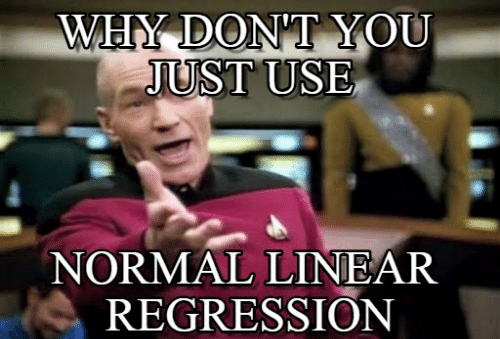

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_auc_score

pred = np.zeros((len(test_data),))
oof = np.zeros((len(X),))

for fold, (idx_train, idx_valid) in enumerate(StratifiedKFold(n_splits=40, shuffle=True, random_state=1).split(X, y)):
    # create train, validation sets
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    model = ElasticNet(**{'alpha': 0.0015412726903594538, 'l1_ratio': 0.7869769839930754, 'max_iter': 25340})
    model.fit(X_train, y_train)
    
    # validation prediction
    oof[idx_valid] = model.predict(X_valid)
    score = roc_auc_score(y_valid, oof[idx_valid])
    
    print(f"Fold: {fold + 1} Score: {score}")
    print("--"*20)
    
    # test prediction based on oof_set
    pred += model.predict(test_data) / 10
    
# print overall validation scores
print(f"Overall Validation Score | Meta: {roc_auc_score(y, oof)}")
print("::"*20)

In [ ]:
# create submission file
stacked_submission = sample_submission.copy()
stacked_submission["target"] = pred
stacked_submission.to_csv("stacked_submission.csv", index=False)